# Modelo de disperção do fogo em queimadas 
## Abordagem simplificada

O seguinte código visa aplicar computacionalmente uma das inúmeras abordagens de modelagem matemática da velocidade de disperção do fogo. O algoritmo adotado foi fundamentado na tese de doutorado: "Propagação do Fogo e Equações Estocásticas" realizada por Andre Telles Campos. 

Esse código não se encontra em máximo detalhamento uma vez que trata-se de uma prova de conceito, para evidênciar a real viabilidade da ideia. Existem muito modelos de previsão de disperção do fogo que poderiam ser elaborados caso obtivéssemos mais tempo.  

# Equações de propagação
De acordo com a pesquisa escolhida, o incêndio em materiais descontínuos (como incêndios florestais, aglomerados residênciais urbanos) deve ser tratado como uma disperção em um meio "repleto de vazios", e, dessa forma, deve-se estudar a densidade média* $ \rho_b $, definida como a razão entre massa de material combustível e do material combustível e seu volume total ocupado, incluido os vazios. 

Ademais, considerando o material combustível como "material combustível fino", isto é, materiais que demonstram menos de 2mm de espessura, teremos a seguinte fórmula de aplicação, em que $ \upsilon $ representa a velocidade de propagação do fogo: 

$$ \upsilon = \frac{C}{\rho_b} $$

Com C aproximadamente $ 0,07 kg/m^3 $ para combustíveis florestais (árvores) de 3cm de diâmetro. 

Vale observar, que, das variáveis exploradas em nossas pesquisas relacionadas ao tema e que definiriam a propagação do incêndio, segundo especialistas da área e bombeiros, quase todas estariam sendo levadas em consideração de alguma forma por essa equação, com exceção do relevo e do vento.

Para a contemplação do vento em nossos cálculos porém, utilizaremos a fórmula proposta por Thomas, P.H, na qual, para um vento com a mesma direção da disperção e com velocidade $ U_{\infty} $, teremos:

$$ \upsilon = (1 + U_{\infty}) \frac{C}{\rho_b} $$

Essa equação, que seria a fórmula mais simples para a aplicação de um modelo determinístico, será utlizada por nós na tentativa de prever a evolução de um incêndio através de uma imagem de infra-vermelho, como a dada a seguir. 

![](images.png)

Para isso, utilizaremos uma segmentação de imagem atrelada com uma manipulação de matrizes com Python. 

In [179]:
# importando bibliotecas necessárias
import numpy as np                 # manipulação de matriz
import matplotlib.pyplot as plt
import cv2

## Trabalhando com a imagem a ser utilizada
Vamos agora analisar a imagem e aplicar uma máscara para que seja possível produzir uma matriz do mapa capaz de diferenciar entre regiões as quais estão ocorrendo queimadas ou não. Para que isso seja possível, vamos primeiramente, identificar o padrão de coloração da imagem no sistema RGB para conseguir produzir limites úteis de diferenciação.

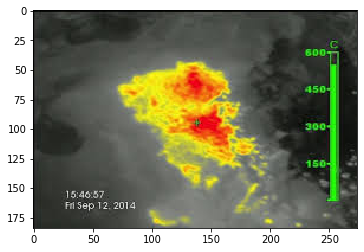

In [180]:
nemo = cv2.imread('images.png')
nemo = cv2.cvtColor(nemo, cv2.COLOR_BGR2RGB)
plt.imshow(nemo)
plt.show()

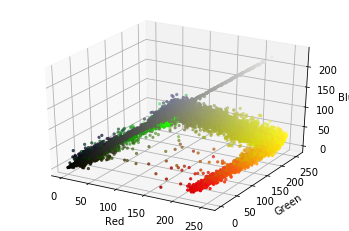

In [181]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

r, g, b = cv2.split(nemo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = nemo.reshape((np.shape(nemo)[0]*np.shape(nemo)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

Analisando o gráfico acima, podemos concluir que é possível diferenciar facilmente as cores mais claras da imagem com as mais escuras, nos permitindo encontrar limites para a produção da máscara, como vista a seguir.

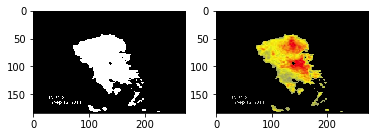

In [182]:
Limite_min = (150,0,0)
Limite_max = (255, 255, 255)

mask = cv2.inRange(nemo, Limite_min, Limite_max)

result = cv2.bitwise_and(nemo, nemo, mask=mask)


plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

## Utilizando a máscara
Como trata-se de uma solução simplificada, utilizaremos apenas a máscara que realizou divisões binárias na imagem, uma vez que não estamos criando um sistema sem diferenciação de temperatura do fogo. 

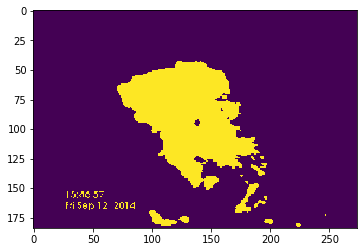

In [183]:
plt.imshow(mask)
plt.show()

A máscara agora apresenta um resultado binário entre "fogo", representado pelo pixel com valor máximo de 255, e "não-fogo" representado pelo valor mínimo de zero.

Assim, podemos utilizar essa matriz de forma a desenvolver uma lógica de espalhamento de fogo, adotando um sentido de vento e velocidade hipotética, que "moveria" o incêndio a cada quantidade determinada de tempo. Teremos a evolução do incêndio. 

## Determinação da Velocidade de Propagação do Vento
De acordo com nossas pesquisas desenvolvidas com a plataforma Wolfram Alfa, usualmente para florestas densas como, a Floresta Amazônica, teríamos uma densidade média de $0,8 km/m^3$ e, considerando C como 0.07, teremos a seguinte função que define a velocidade de disperção do fogo com base na velocidade do vento. 

In [184]:
def velocidade_fogo(vel_vento, C=0.07, rho=0.8):
    
    fogo = (1+vel_vento)*C/rho
    return fogo


## Determinar evolução do incêndio
Utilizando uma lógica binária na qual, a cada dado período de tempo, o pixel da imagem (tratado como 10 metros quadrados de terreno real) apresentará uma situação de "fogo caso seu pixel imediatamente anterior (definido como o picel oposto do sentido do vento) demonstre situação de fogo.   

Considerando um caso de incêndio no município de Limeira-SP, com velocidade de vento de 4 metros por segundo, no sentido Leste, teremos a seguinte lógica:

In [185]:
def projecao_area_queimada(mapa_np, vel_vento, tempo_decorrido,C=0.07,rho=0.8, escala=10):
    
    mapa_atual = mapa_np.tolist()
    novo_mapa = [row[:] for row in mapa_atual]
    
    vel_fogo = velocidade_fogo(vel_vento)
    
    distancia_percorrida = vel_fogo * tempo_decorrido
    
    num_pixels_percorridos = int(distancia_percorrida/escala)
    
    #iterar sobre oos pixels anteriores
    #para o caso do sentido leste, teremos:
    for i in range(len(mapa_atual)):
        for j in range(len(mapa_atual[0])):
            #se algum dos pixels anteriores ao numero de pixels percorridos apresentar situacao de fogo, 
            #o pixel referenciado estara em chamas
            
            for k in range(1, num_pixels_percorridos+1):
                if j-k >= 0:
                    if mapa_atual[i][j-k]!=0:
                        novo_mapa[i][j] = 255
                        
         
    mapa_array = np.array(novo_mapa)
    plt.imshow(mapa_array)
    plt.title(f'Projecao para area queimando depois de {tempo_decorrido} segundos')
    plt.show()

Com o código exposto, podemos criar mapas de evolução do fogo de fogo com base no tempo decorrido, vistos abaixo. 

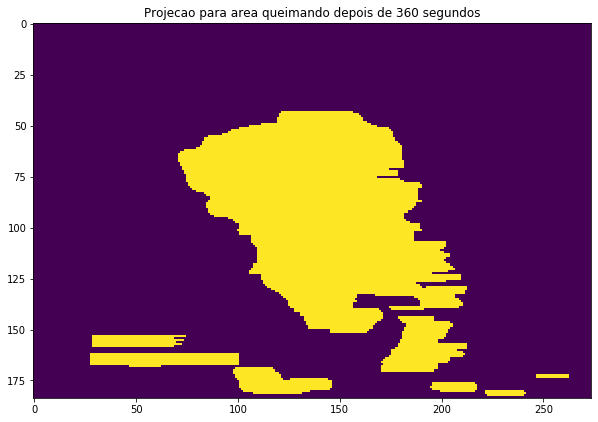

In [186]:
plt.figure(figsize=(10,8))
projecao_area_queimada(mask, 4, 360)

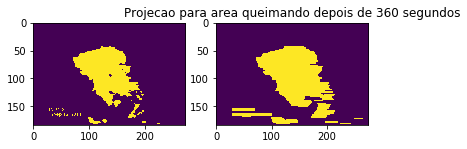

In [187]:
plt.subplot(1, 2, 1)
plt.imshow(mask)
plt.subplot(1, 2, 2)
projecao_area_queimada(mask,4,360)
plt.show()

## Evolução do caso abordado

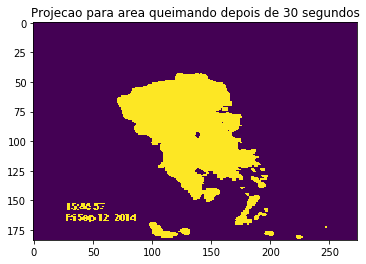

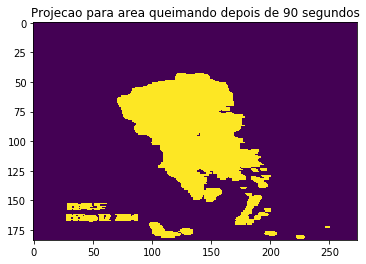

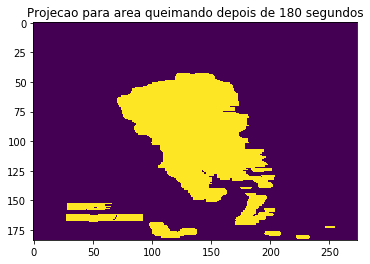

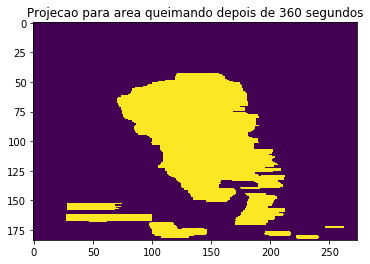

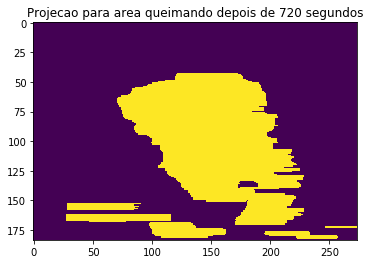

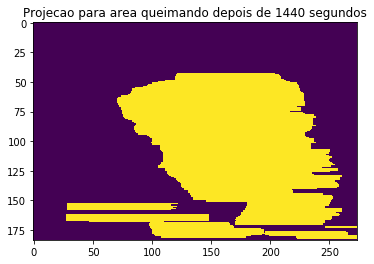

In [188]:
for time in [30,90,180,360,720,1440]:
    projecao_area_queimada(mask,4,time)

# Conclusão
Por fim, podemos concluir que é possível realizar as simulações computacionais para a criação de estratégias de combate ao fogo, assim como realizar o processamento das imagens fornecidas pelos drones. Infelizmente, devido a escassez do tempo, não foi possível a realização de um deploy contínuo nem de uma abstração maior da ideia. Entretanto, esperamos que seja possível compreender a viabilidade do projeto.  